In [1]:
import os

os.environ['DASHSCOPE_API_KEY'] = 'sk-e2a05bbcfac84e53b73f98acef15a009'

# Step 0: Define tools and model

from langchain_core.tools import tool
from langchain_community.chat_models.tongyi import ChatTongyi

llm = ChatTongyi(
    model="qwen-max",   # 此处以qwen-max为例，您可按需更换模型名称。模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models
    streaming=True,
    # other params...
)

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

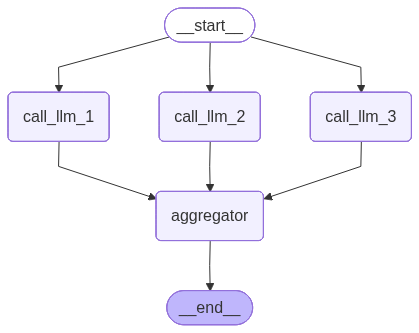

In [3]:

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [4]:

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
In the heart of a bustling city, nestled between towering skyscrapers and busy streets, lay a hidden gem: a small, enchanting garden. This garden was no ordinary place; it was a sanctuary for a group of cats, each with their own unique story and personality.

At the center of the garden stood an ancient, gnarled tree, its branches reaching out like welcoming arms. Beneath this tree, a wise old cat named Whisker lived. Whisker had been in the garden longer than any of the other cats could remember, and he was the unofficial leader of the feline community. His fur was a soft, silvery gray, and his eyes held the wisdom of countless sunrises and moonlit nights.

One sunny morning, a tiny, scruffy kitten stumbled into the garden. Her fur was matted, and her eyes were wide with fear and wonder. The other cats, curious but cautious, watched from a distance as the little one explored her new surroundings. Whisker, sensing the kitten's distress